In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import copy

np.set_printoptions(precision=2)

# Demonstation of Direct and Indirect Perspective Mapping

This notebook presents how obtain a top-down view of a plane based on a front-facing camera image. The method only requires intrinsic and extrinsic camera parameters.

Ref: M. Olivera, V. Santos, A. Sappa, "Multimodal inverse perspective mapping" (2015)

# Read image

The array indices correspond to 'image frame' coordinates

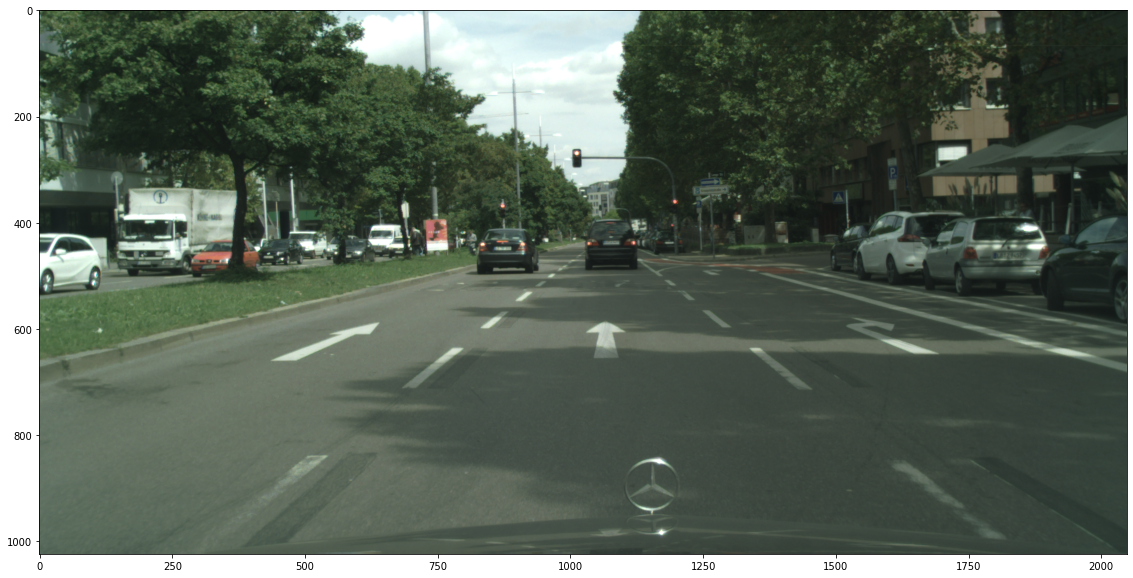

Image (height, width) = (1024, 2048)


In [2]:
img = cv2.cvtColor(cv2.imread("stuttgart_01_000000_003715_leftImg8bit.png"), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
plt.imshow(img)
plt.show()

# Size of the image (in pixels)
IMG_H, IMG_W, IMG_C = img.shape
print(f"Image (height, width) = ({IMG_H}, {IMG_W})")

# Define camera intrisic and extrinsic parameters

The intrinsic parameters are obtained from the camera specification, while the extrinsic parameters are obtained from calibration procedures applied on the actual configuration.

In [3]:
# [rad]
pitch = 0.03842560000000292
roll = 0.0
yaw = 0.026239999999999368

# [m]
x = 1.7
y = 0.026239999999999368
z = 1.212400000000026

# [px]
fx = 2263.54773399985
fy = 2250.3728170599807
u0 = 1079.0175620000632
v0 = 515.0066006000195

# Computing matrices

Here it is assumed that the vehicle reference frame origo lies on the plane of interest. In other words, the plane we want to project on is the plane in the vehicle reference frame with Z = 0.

In [4]:
def rotation_matrix(roll, pitch, yaw):
    """
    """
    si, sj, sk = np.sin(roll), np.sin(pitch), np.sin(yaw)
    ci, cj, ck = np.cos(roll), np.cos(pitch), np.cos(yaw)
    cc, cs = ci * ck, ci * sk
    sc, ss = si * ck, si * sk

    R = np.identity(3)
    R[0, 0] = cj * ck
    R[0, 1] = sj * sc - cs
    R[0, 2] = sj * cc + ss
    R[1, 0] = cj * sk
    R[1, 1] = sj * ss + cc
    R[1, 2] = sj * cs - sc
    R[2, 0] = -sj
    R[2, 1] = cj * si
    R[2, 2] = cj * ci
    return R

In [5]:
# Intrinsic parameter matrix
K = np.array([[fx, 0, u0],
              [0, fy, v0],
              [0,  0,  1]])

# Camera -> Road transformation (given)
R_cam2road = rotation_matrix(roll, pitch, yaw)
T_cam2road = np.array([[x, y, z]]).T

# Road -> Camera transformation (wanted)
R_road2cam = R_cam2road.T
T_road2cam = - T_cam2road

# Camera -> Image transformation added to the 'K' matrix
# NOTE: The cam2img rotation matrix is inductively derived to perform the desired transformation
#       Camera frame       Image frame
#           x_cam     -->    -y_img
#           y_cam     -->    -z_img
#           z_cam     -->     x_img
#
#       {v_cam}^T R_cam2img = {v_img}^T
#
R_cam2img = np.array([[0, -1, 0],
                      [0, 0, -1],
                      [1, 0,  0]])
C = K @ R_cam2img

# Compute 'P' matrix and 't' vector mapping 'World coordinate Q' -> 'Image coordinate q_h'
P = C @ R_road2cam
t = C @ T_road2cam

# Projection functions

The direct projection transforms a 'world coordinate' point into the corresponding 'image coordinate' point.

The indirect projection is the opposite of the direct transformation, meaning a 'image coordinate' point gets transformed into a 'world coordinate' point.

In [6]:
def direct_projection(world_vec, P, t, eps=1e-24):
    '''Transforms a point from 'world coordinates' (x_W, y_W, z_W) [m] -> 'image coordinates' (x_I, y_I) [px]
    
    Args:
        world_vec: Column vector (3,1) [m]
        P: Rotation matrix (world -> image coordinates)
        t: Translation vector (world -> image coordinates)
    
    Returns:
        Image coordinate vector representing (x_I, y_I) pixel location of world coordinates (x_W, y_W, z_W)
    '''
    img_vec = P @ world_vec + t
    img_vec = img_vec[:2,:] / (img_vec[2,:] + eps)
    
    return img_vec
    
world_vec = np.array([[100, 0, 0]]).T
img_vec = direct_projection(world_vec, P, t)
print(img_vec)

[[1140.1 ]
 [ 454.78]]


In [7]:
def inverse_projection(img_x, img_y, P, t):
    '''Transforms a point from 'image coordinates' (x_I, y_I) [px] -> 'world (plane) coordinates' (x_W, y_W, z_W) [m] where z = 0
    
    Args:
        img_x: Image 'x' coordinate [px]
        img_y: Image 'y' coordinate [px]
        P: Rotation matrix (world -> image coordinates)
        t: Translation vector (world -> image coordinates)
        
    Returns:
        World coordinate vector (x_W, y_W, z_W) [m] representing road plane location of image coordinate (x_I, y_I)
    '''
    
    # Inverted matrix
    A = np.zeros((4,4))
    A[0:3,0:3] = P
    A[0, 3] = -img_x
    A[1, 3] = -img_y
    A[2, 3] = -1
    A[3,2] = 1
    
    A_inv = np.linalg.inv(A)
    
    # Column vector
    t_vec = np.zeros((4,1))
    t_vec[0:3,:] = -t
    
    world_coord = A_inv @ t_vec
    
    return world_coord[:3]

world_vec = inverse_projection(1140.1, 481.99, P, t)
print(world_vec)

[[ 5.00e+01]
 [ 3.61e-02]
 [-8.22e-17]]


# Projection

### Inferring sptial coverage

Applying the inverse projection transformation, it is possible to obtain what image coordinate (i.e. what pixel) corresponds to a predetermined maximum projection range (i.e. furthest distance point in 'world coordinates').

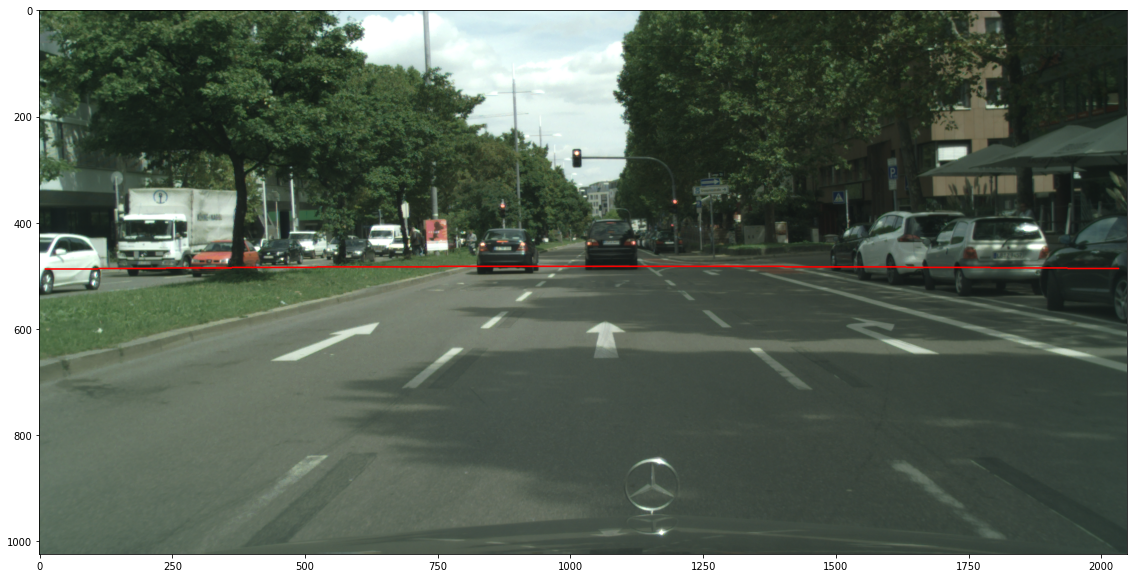

In [8]:
max_distance = 50.0  # [m]


# Compute 'world coordinate' points corresponing to the half-circle with radius 'max_distance' away from the ego-vehicle
line_N = 400
view_angles = np.linspace(-0.5*np.pi, 0.5*np.pi, line_N)

xs = []
ys = []
zs = []

for view_angle in view_angles:
    
    x = np.cos(view_angle) * max_distance
    y = np.sin(view_angle) * max_distance
    
    xs.append(x)
    ys.append(y)
    zs.append(0.)


# Project these 'world coordinates' into corresponding 'image coordinates'
world_vec = np.array([xs, ys, zs])

img_vec = direct_projection(world_vec, P, t)


# Filter out the set of points not contained within the image frame (i.e. the pixel range correponding to the input image)
img_xs = []
img_ys = []

for pnt_idx in range(img_vec.shape[1]):
    
    img_x = int(np.round(img_vec[0, pnt_idx]))
    img_y = int(np.round(img_vec[1, pnt_idx]))
    
    if img_x < 0 or IMG_W-1 < img_x:
        continue
    
    if img_y < 0 or IMG_H-1 < img_y:
        continue
    
    img_xs.append(img_x)
    img_ys.append(img_y)

# Draw the top-down "border of vision" representing 'max_distance' [m]

img_boundary_viz = copy.deepcopy(img)

for pnt_idx in range(len(img_xs)-1):
    x0 = img_xs[pnt_idx]
    x1 = img_xs[pnt_idx+1]
    y0 = img_ys[pnt_idx]
    y1 = img_ys[pnt_idx+1]
    img_boundary_viz = cv2.line(img_boundary_viz, (x0,y0), (x1,y1), (255, 0, 0), 2)
    
plt.figure(figsize=(20,10))
plt.imshow(img_boundary_viz)
plt.show()

It is clear that the line is approximately horizontal, meaning we can approximate the pixels corresponing to 50 m away as all pixels lying bellow the pixel at 50m ahead of the vehicle.

In [9]:
world_vec = np.array([[50., 0., 0.]]).T
img_vec = direct_projection(world_vec, P, t)

print(img_vec)

img_y_min_limit = int(np.round(img_vec[1,0]))

print(img_y_min_limit)

[[1141.8 ]
 [ 481.99]]
482


The road plane reference frame is centered at the vehicle reference frame.

The bottom line of the image (the closest image information) correspond to the following spatial location.

In [10]:
print(f"Projection starts {inverse_projection(1024-1, 2048/2, P, t)[0,0]:.2f} [m] ahead of the vehicle reference frame origo")
print(f"Projection ends {inverse_projection(1140.1, 481.99, P, t)[0,0]:.2f} [m] ahead of the vehicle reference frame origo")

Projection starts 6.03 [m] ahead of the vehicle reference frame origo
Projection ends 50.00 [m] ahead of the vehicle reference frame origo


# Projecting camera image into a top-down perspective

### Create a (x,y) grid

Mapping 'world coordinates' to 'image frame coordinates'

In [11]:
x_min = -50
x_max = 50
y_min = -50
y_max = 50

res = 0.05

x_N = int((x_max - x_min) / res)
y_N = int((y_max - y_min) / res)

# Construct a matrix by concatenating column vectors, each representing a point in world coordinates

xs , ys = np.meshgrid(np.linspace(x_min, x_max, x_N), np.linspace(y_min, y_max, y_N))

xs = xs.flatten()
ys = ys.flatten()
zs = np.zeros(xs.shape)

world_vecs = np.array([xs, ys, zs])

print(world_vecs.shape)

(3, 4000000)


In [12]:
# Project all 'world coordinate' vectors (X, Y, Z) into 'image coordinate' vectors (i, j) at once

img_vecs = direct_projection(world_vecs, P, t)

img_vecs = np.reshape(img_vecs, (2, x_N, y_N))
print(img_vecs.shape)

(2, 2000, 2000)


In [13]:
# Draw the top-down image representation "pixel-by-pixel"

bev = np.zeros((x_N, y_N, 3), dtype=np.int32)

for i in range(x_N):
    for j in range(y_N):
        
        # For each pixel (i, j), the correponding location in the image frame is obtained from the previous direct mapping operation
        x_I = img_vecs[0, i, j]
        y_I = img_vecs[1, i, j]
        
        x_I = int(x_I)
        y_I = int(y_I)
        
        # Only map pixels within the given image frame
        if x_I < 0 or IMG_W-1 < x_I :
            continue
        
        # 'img_y_min_limit' correspond to range limit 50m
        if y_I < img_y_min_limit or IMG_H-1 < y_I :
            continue
        
        # Map image frame pixel to world coordinate pixel
        bev[y_N-j, x_N-i] = img[y_I, x_I]

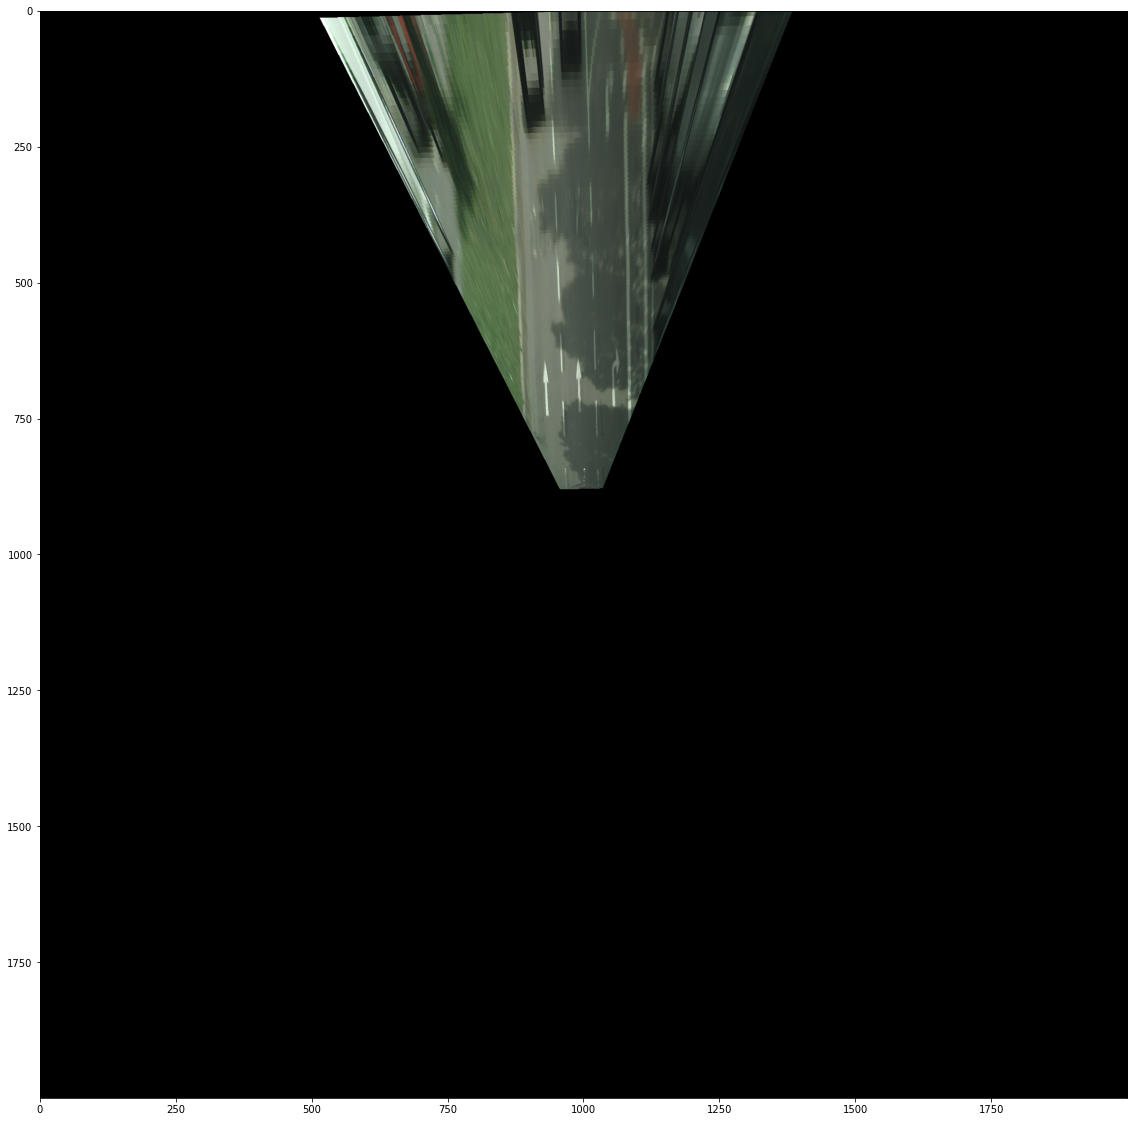

In [14]:
plt.figure(figsize=(20,20))
plt.imshow(bev)
plt.show()